#Part II. Training

In [ ]:
import tensorflow as tf
import pathlib
import random
from google.colab import drive
import os
import matplotlib.pyplot as plt
import tensorflow.keras.applications as CNNs
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Conv2D, \
MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
tf.compat.v1.enable_eager_execution()

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
drive.mount('/content/drive', force_remount=True)
ROOT = '/content/drive/My Drive/applied_deep_learning/project/'

Mounted at /content/drive


**1. Generate training and test data**

In [ ]:
class GenerateDataForMasks(object):
    def __init__(self, level):
        self.level = level
        print('Generating data for level {}...'.format(self.level))
        self.slides_paths_train = None
        self.slides_paths_test = None
        self.masks_paths_train = None
        self.masks_paths_test = None
        self.split_and_mapping_paths()

        self.slides_masks_train = None
        self.slides_masks_test = None
        self.mapping_data()
        self.create_pipeline()

In [ ]:
class GenerateDataForMasks(GenerateDataForMasks):
    def split_and_mapping_paths(self):
        """
        Split the original slides and masks paths into 2 parts for training and 
        validation (test) respectively, and convert them to tensor slices          
        """
        slides_folder = pathlib.Path(os.path.join(ROOT, 'partials/level_{}/slides'.format(self.level)))
        masks_folder = pathlib.Path(os.path.join(ROOT, 'partials/level_{}/tumor_masks'.format(self.level)))
        all_slides_paths = sorted([str(path) for path in list(slides_folder.glob('**/*'))])
        all_masks_paths = sorted([str(path) for path in list(masks_folder.glob('**/*'))])
        self.slides_paths_train, self.slides_paths_test, self.masks_paths_train, self.masks_paths_test = train_test_split(all_slides_paths, 
                                                                                                                          all_masks_paths,
                                                                                                                          test_size=0.15,
                                                                                                                          random_state=1)
        
        self.slides_paths_train = tf.data.Dataset.from_tensor_slices(self.slides_paths_train)
        self.slides_paths_test = tf.data.Dataset.from_tensor_slices(self.slides_paths_test)
        self.masks_paths_train = tf.data.Dataset.from_tensor_slices(self.masks_paths_train)
        self.masks_paths_test = tf.data.Dataset.from_tensor_slices(self.masks_paths_test)
        print('All paths successfully splitted and mapped')        

In [ ]:
class GenerateDataForMasks(GenerateDataForMasks):
    def decode_slide(self, path):
        """
        Read one slide image from the imput path, decode the image, conver it, 
        and rescale it to [0, 1] scale
        Return a tf.Tensor(float32)
        Input:
            path (tf.Tensor(string)): the path of slide image
        """
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image / 255.0

In [ ]:
class GenerateDataForMasks(GenerateDataForMasks):
    def decode_mask(self, path):
        """
        Read one mask image from the imput path, decode the image, conver it, 
        and rescale it to [0, 1] scale
        Return a tf.Tensor(uint32)
        Input:
            path (tf.Tensor(string)): the path of mask image
        """
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.image.convert_image_dtype(image, tf.uint8)
        return image // 255

In [ ]:
class GenerateDataForMasks(GenerateDataForMasks):
    def mapping_data(self):
        """
        Map the slides and masks to images with their corresponding paths and zip
        them together to generate training and validation (test) data
        """
        slides_train = self.slides_paths_train.map(self.decode_slide, num_parallel_calls=AUTOTUNE)
        slides_test = self.slides_paths_test.map(self.decode_slide, num_parallel_calls=AUTOTUNE)
        masks_train = self.masks_paths_train.map(self.decode_mask, num_parallel_calls=AUTOTUNE)
        masks_test = self.masks_paths_test.map(self.decode_mask, num_parallel_calls=AUTOTUNE)

        self.slides_masks_train = tf.data.Dataset.zip((slides_train, masks_train))
        self.slides_masks_test = tf.data.Dataset.zip((slides_test, masks_test))
        print('All image data successfully mapped and zipped.')

In [ ]:
class GenerateDataForMasks(GenerateDataForMasks):
    def create_pipeline(self):
        """
        Create pipelines for training data and test data to accelerate data 
        importing during the training process
        """
        self.slides_masks_train = self.slides_masks_train.shuffle(SHUFFLE_SIZE)
        self.slides_masks_train = self.slides_masks_train.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
        self.slides_masks_train= self.slides_masks_train.repeat()
        self.slides_masks_test = self.slides_masks_test.batch(BATCH_SIZE).repeat()
        print('All pipelines successfully created.\n')

**2. Run the training and validation data generating process**

In [ ]:
generate_3 = GenerateDataForMasks(level=3)
generate_4 = GenerateDataForMasks(level=4)
generate_5 = GenerateDataForMasks(level=5)

Generating data for level 3...
All paths successfully splitted and mapped
All image data successfully mapped and zipped.
All pipelines successfully created.

Generating data for level 4...
All paths successfully splitted and mapped
All image data successfully mapped and zipped.
All pipelines successfully created.

Generating data for level 5...
All paths successfully splitted and mapped
All image data successfully mapped and zipped.
All pipelines successfully created.



**3. Construct training models**

In [ ]:
class TrainingForMasks(object):
    def __init__(self, input_dim, num_filters, dropout_rate):
        self.input_dim = input_dim
        self.UNet = None
        self.build_unet(n_filters=num_filters, dropout=dropout_rate)
        self.history = None

In [ ]:
class TrainingForMasks(TrainingForMasks):
    def build_single_layer(self, input_tensor, n_filters, kernel_size=3, batchnorm=True):
        """
        Add 2 convolutional layers with the parameters passed to it
        Return a tf.layer
        Input:
            input_tensor (tf.layer): tensorin the previous layer to be processed
            n_filters (int): number of filters in the layer
            kernel_size (int): size of the kernel that scan the convolutional layer
            batchnorm (bool): include batch normalization in the layer or not
        """
        # first layer
        layer = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                       kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
        if batchnorm:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        # second layer
        layer = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                       kernel_initializer = 'he_normal', padding = 'same')(layer)
        if batchnorm:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        
        return layer    

In [ ]:
class TrainingForMasks(TrainingForMasks):
    def build_unet(self, n_filters, dropout, batchnorm=True):
        """
        build up te whole UNet with the self.build_single_layer function
        Input:
            n_filters (int): number of filters in the layer
            dropout (float): dropout rate in the Dropout layer to reduce overfitting
            batchnorm (bool): include batch normalization in the layer or not
        """
        input_img = Input(self.input_dim)
        # Contracting Path
        c1 = self.build_single_layer(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        p1 = MaxPooling2D((2, 2))(c1)
        p1 = Dropout(dropout)(p1)
        
        c2 = self.build_single_layer(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        p2 = MaxPooling2D((2, 2))(c2)
        p2 = Dropout(dropout)(p2)
        
        c3 = self.build_single_layer(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        p3 = MaxPooling2D((2, 2))(c3)
        p3 = Dropout(dropout)(p3)
        
        c4 = self.build_single_layer(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        p4 = MaxPooling2D((2, 2))(c4)
        p4 = Dropout(dropout)(p4)
        
        c5 = self.build_single_layer(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
        
        # Expansive Path
        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
        u6 = concatenate([u6, c4])
        u6 = Dropout(dropout)(u6)
        c6 = self.build_single_layer(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        
        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
        u7 = concatenate([u7, c3])
        u7 = Dropout(dropout)(u7)
        c7 = self.build_single_layer(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        
        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
        u8 = concatenate([u8, c2])
        u8 = Dropout(dropout)(u8)
        c8 = self.build_single_layer(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        
        u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
        u9 = concatenate([u9, c1])
        u9 = Dropout(dropout)(u9)
        c9 = self.build_single_layer(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
        self.UNet = Model(inputs=[input_img], outputs=[outputs])
        print('UNet successfully built.')

In [ ]:
class TrainingForMasks(TrainingForMasks):
    def compile_and_fit(self, data_train, data_val, epochs):
        """
        Complie and fit the UNet model
        Input:
            data_train: training data (zipped slides and masks)
            data_val: validation data (zipped slides and masks)
            epochs (int): total running times of the training process
        """
        self.UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.history = self.UNet.fit(data_train, epochs=epochs, steps_per_epoch=100,
                                     validation_data=data_val, validation_steps=50)

In [ ]:
class TrainingForMasks(TrainingForMasks):    
    def create_mask(self, pred_mask):
        """
        Create the mask pixels in the predicted mask
        Return a np.array()
        Input:
            pred_mask (tf.Tensor): predicted mask obtained with the model
        """
        pred_mask = pred_mask[0]
        pred_mask = np.where(pred_mask > 0.5, 1, 0)
        return pred_mask

In [ ]:
class TrainingForMasks(TrainingForMasks):    
    def display(self, display_list):
        """
        Plot the original slide image, true tumor mask image and the predicted 
        tumor mask image for comparison
        Input: 
            display_list (List[np.array]): slide image, true mask and predicted mask
        """
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()

In [ ]:
class TrainingForMasks(TrainingForMasks):
    def evaluate(self, data_test, test_num):
        """
        Predict the possible mask of the inserting test data
        Input:
            data_test (tf.Tensor): test data consisting of a small part in the zipped data
            test_num (int): number of samples we run for evaluation
        """
        for slide, mask in data_test.take(test_num):
            pred_mask = self.UNet.predict(slide)
            self.display([slide[0], mask[0], self.create_mask(pred_mask)])

In [ ]:
class TrainingForMasks(TrainingForMasks):
    def draw_curves(self):
        """
        Plot the history of loss and accuracy in training and validation data
        """
        train_acc, train_loss = self.history.history['accuracy'], self.history.history['loss']
        val_acc, val_loss = self.history.history['val_accuracy'], self.history.history['val_loss']
        epochs = range(len(train_acc))

        figure = plt.figure(figsize=(20,10))

        plt.subplot(121)
        plt.title('Training and validation accuracy')
        plt.plot(epochs, train_acc, color='blue', label='Training')
        plt.plot(epochs, val_acc, color='orange', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(122)
        plt.title('Training and validation loss')
        plt.plot(epochs, train_loss, color='blue', label='Training')
        plt.plot(epochs, val_loss, color='orange', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

**4. Build, train, and evaluate models**

We also plot the architecture and summary of the model, as shown below.

UNet successfully built.


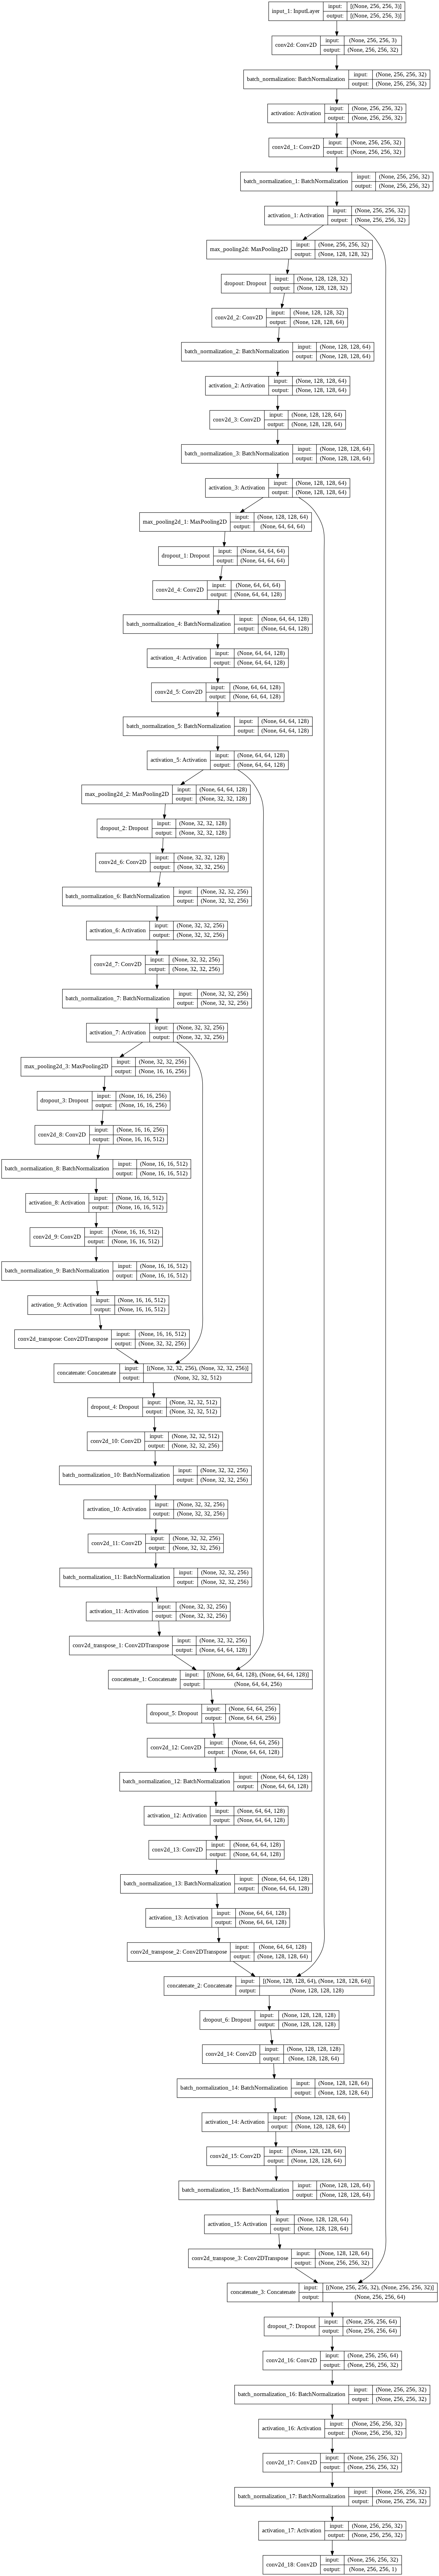

In [ ]:
training_mask_3 = TrainingForMasks(input_dim=(IMG_SIZE, IMG_SIZE, 3),
                                   num_filters=32,
                                   dropout_rate=0.3)
tf.keras.utils.plot_model(training_mask_3.UNet, show_shapes=True)

In [ ]:
training_mask_3.UNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
training_mask_3.compile_and_fit(data_train=generate_3.slides_masks_train,
                                data_val=generate_3.slides_masks_test,
                                epochs=30)

Epoch 1/30
100/100 [==============================] - 937s 7s/step - loss: 0.5694 - accuracy: 0.7048 - val_loss: 2.3789 - val_accuracy: 0.6426
Epoch 2/30
100/100 [==============================] - 101s 1s/step - loss: 0.3383 - accuracy: 0.8507 - val_loss: 1.9072 - val_accuracy: 0.7218
Epoch 3/30
100/100 [==============================] - 99s 994ms/step - loss: 0.2936 - accuracy: 0.8735 - val_loss: 1.5431 - val_accuracy: 0.7934
Epoch 4/30
100/100 [==============================] - 99s 992ms/step - loss: 0.2509 - accuracy: 0.9004 - val_loss: 0.7649 - val_accuracy: 0.7925
Epoch 5/30
100/100 [==============================] - 99s 991ms/step - loss: 0.2541 - accuracy: 0.8960 - val_loss: 0.6383 - val_accuracy: 0.7256
Epoch 6/30
100/100 [==============================] - 97s 969ms/step - loss: 0.2235 - accuracy: 0.9091 - val_loss: 4.7787 - val_accuracy: 0.6332
Epoch 7/30
100/100 [==============================] - 99s 990ms/step - loss: 0.2364 - accuracy: 0.9045 - val_loss: 0.4685 - val_accura

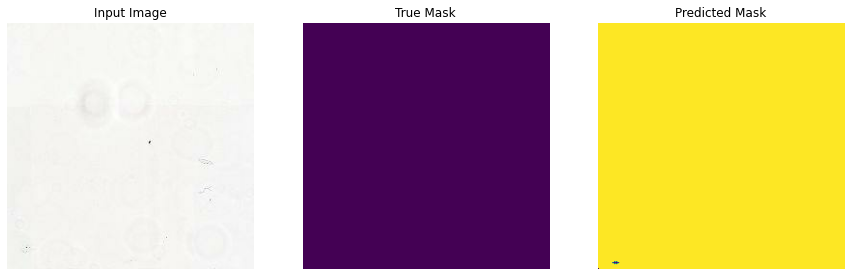

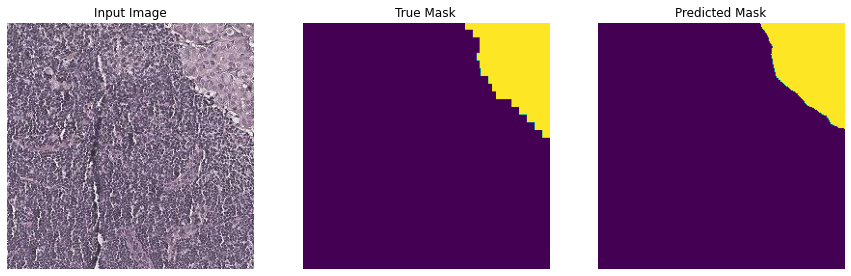

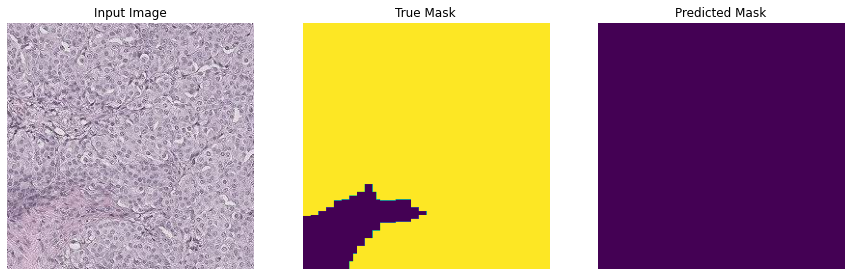

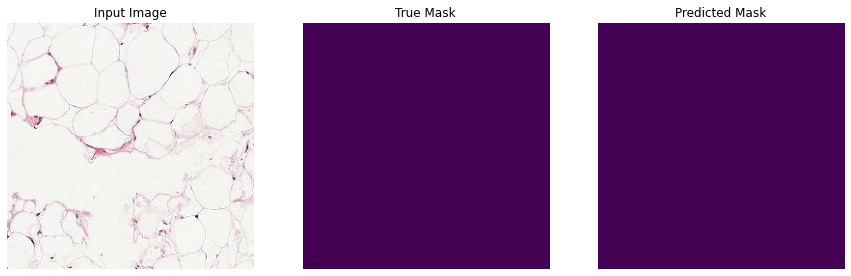

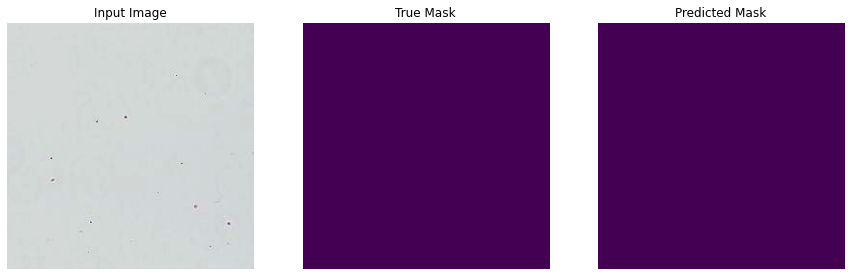

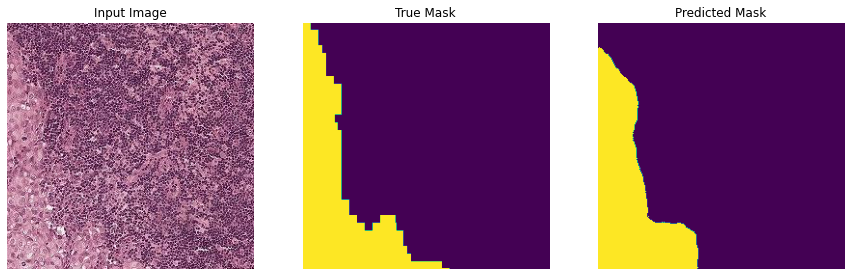

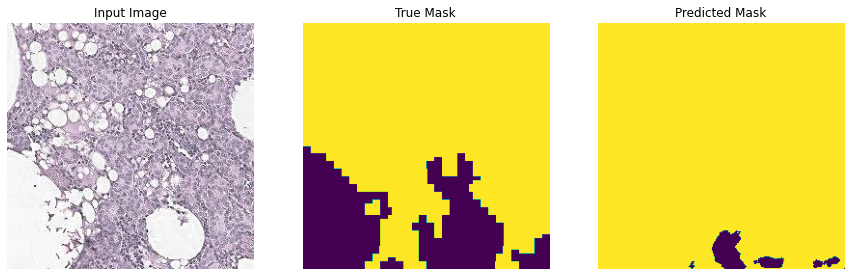

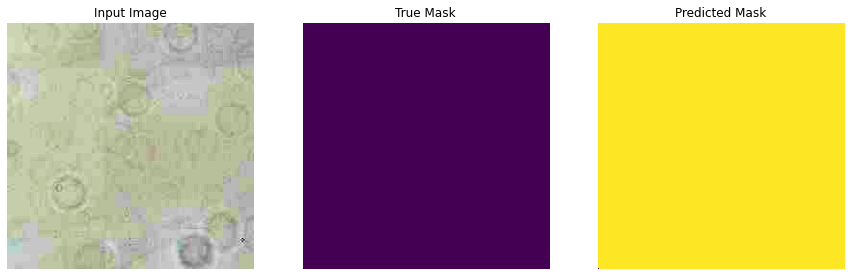

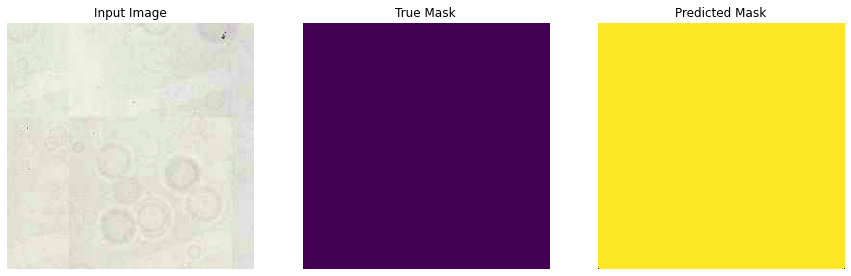

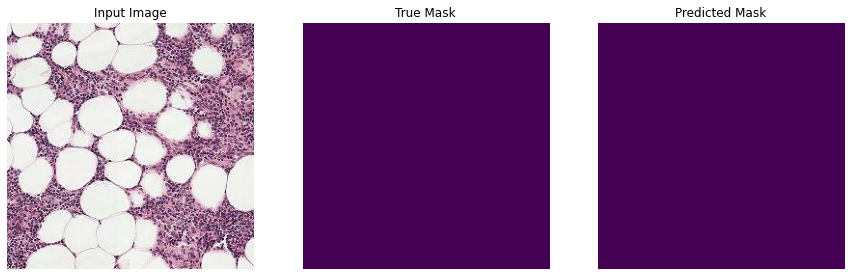

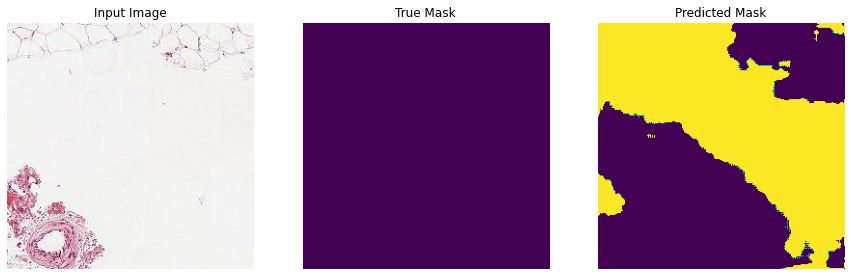

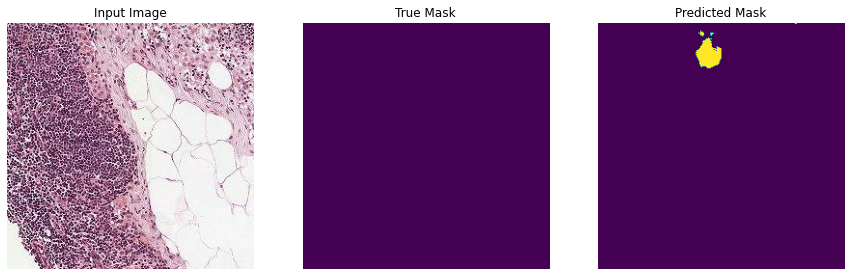

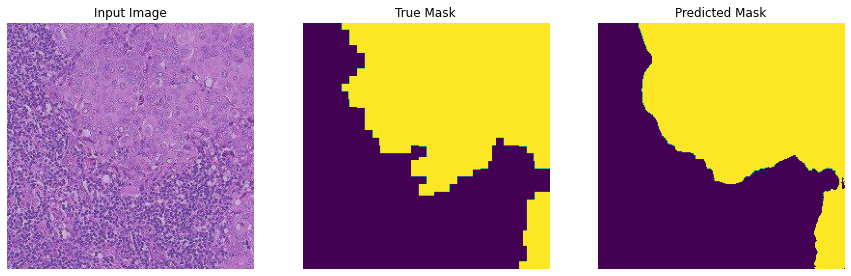

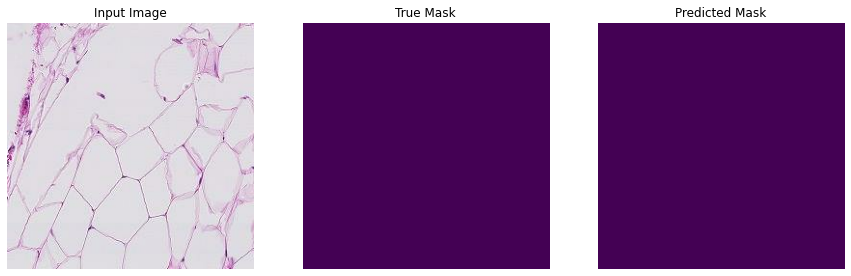

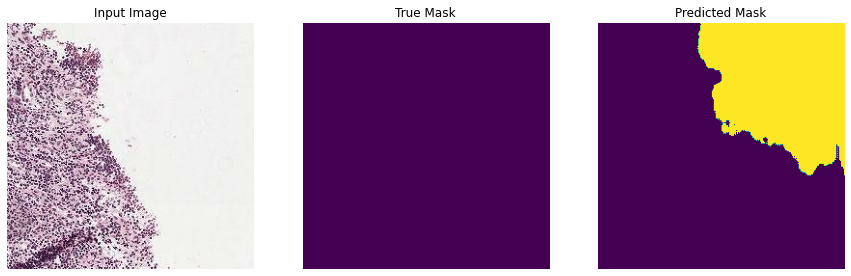

In [ ]:
training_mask_3.evaluate(data_test=generate_3.slides_masks_test,
                         test_num=15)

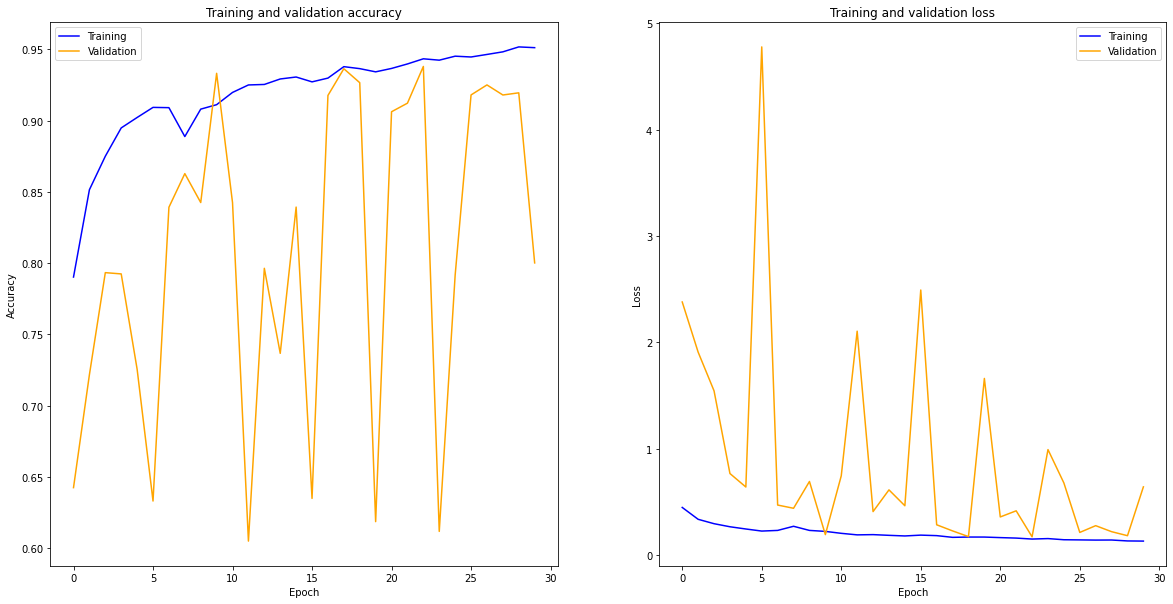

In [ ]:
training_mask_3.draw_curves()

In [ ]:
training_mask_3.UNet.save(ROOT + 'UNet_level_3.h5', overwrite=True)

In [ ]:
training_mask_4 = TrainingForMasks(input_dim=(IMG_SIZE, IMG_SIZE, 3),
                                   num_filters=32,
                                   dropout_rate=0.3)

UNet successfully built.


In [ ]:
training_mask_4.compile_and_fit(data_train=generate_4.slides_masks_train,
                                data_val=generate_4.slides_masks_test,
                                epochs=30)

Epoch 1/30
100/100 [==============================] - 921s 7s/step - loss: 0.6895 - accuracy: 0.6094 - val_loss: 0.9890 - val_accuracy: 0.5522
Epoch 2/30
100/100 [==============================] - 99s 993ms/step - loss: 0.3673 - accuracy: 0.8541 - val_loss: 3.1938 - val_accuracy: 0.2831
Epoch 3/30
100/100 [==============================] - 99s 994ms/step - loss: 0.2925 - accuracy: 0.8820 - val_loss: 4.7627 - val_accuracy: 0.4612
Epoch 4/30
100/100 [==============================] - 99s 989ms/step - loss: 0.2630 - accuracy: 0.8956 - val_loss: 1.9164 - val_accuracy: 0.4520
Epoch 5/30
100/100 [==============================] - 99s 990ms/step - loss: 0.2359 - accuracy: 0.9086 - val_loss: 1.0732 - val_accuracy: 0.6956
Epoch 6/30
100/100 [==============================] - 97s 967ms/step - loss: 0.2188 - accuracy: 0.9128 - val_loss: 3.0422 - val_accuracy: 0.3907
Epoch 7/30
100/100 [==============================] - 99s 988ms/step - loss: 0.2013 - accuracy: 0.9217 - val_loss: 0.3077 - val_accu

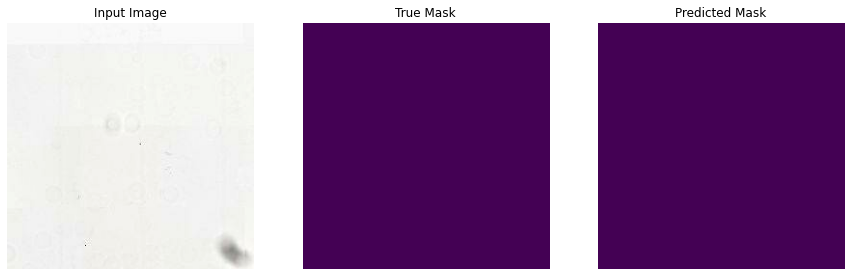

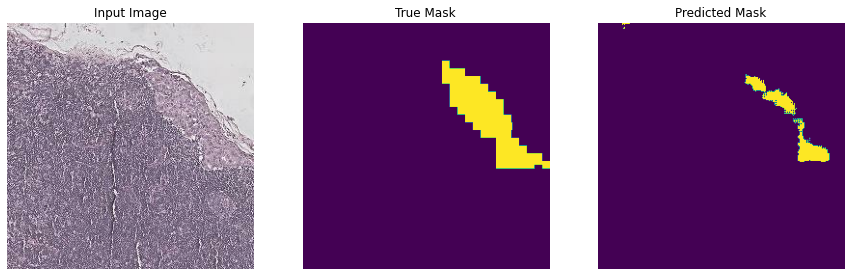

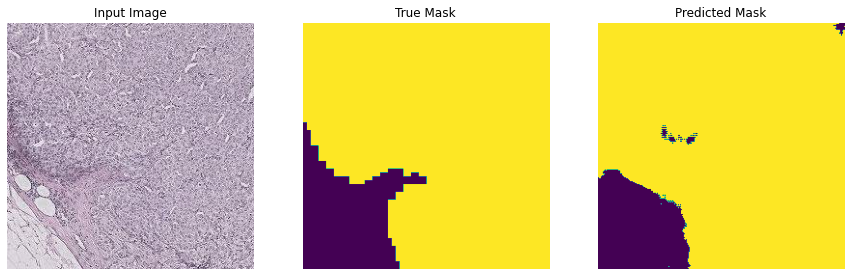

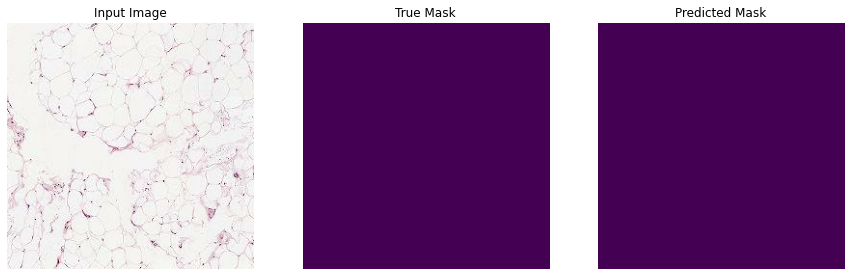

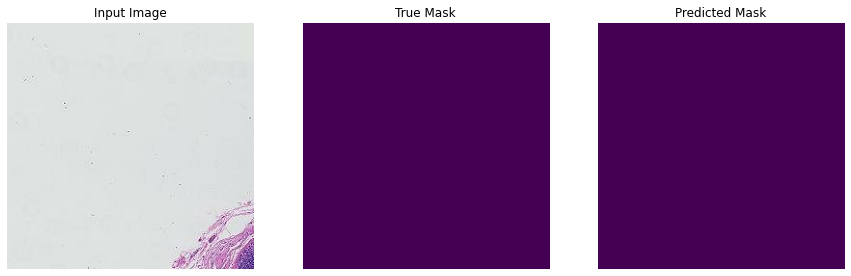

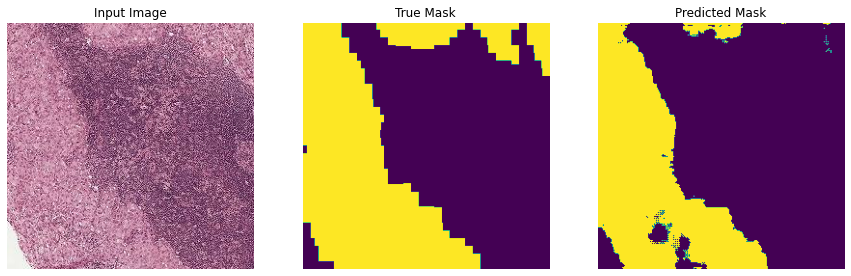

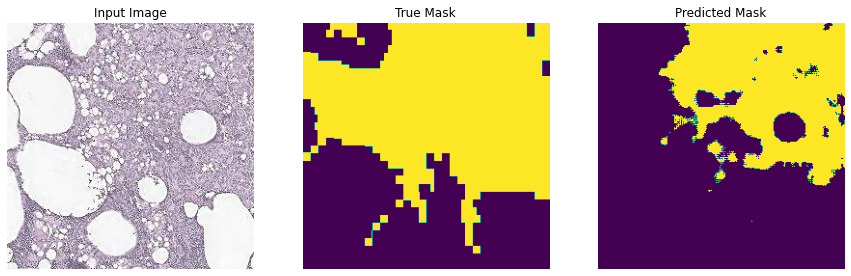

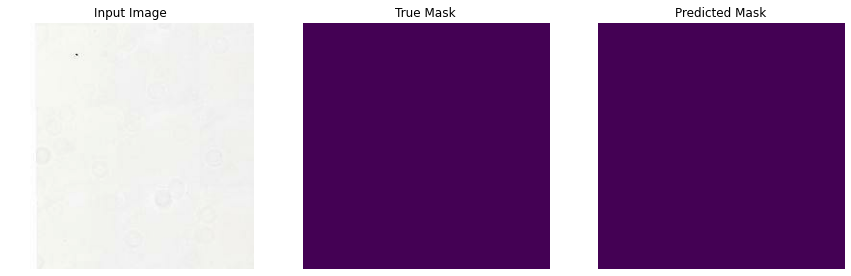

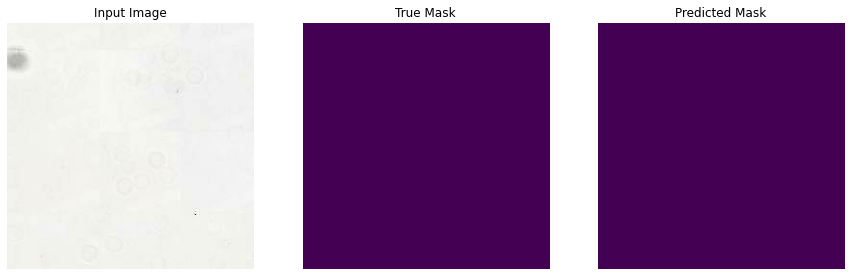

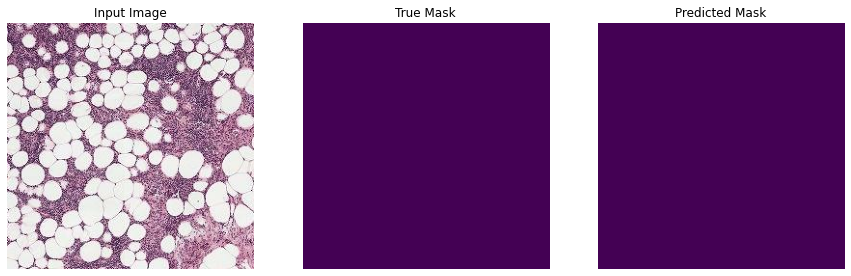

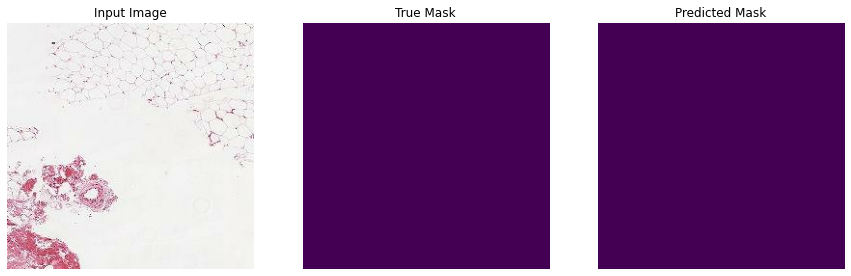

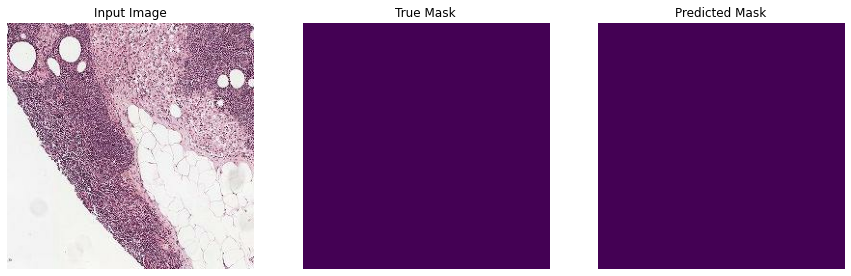

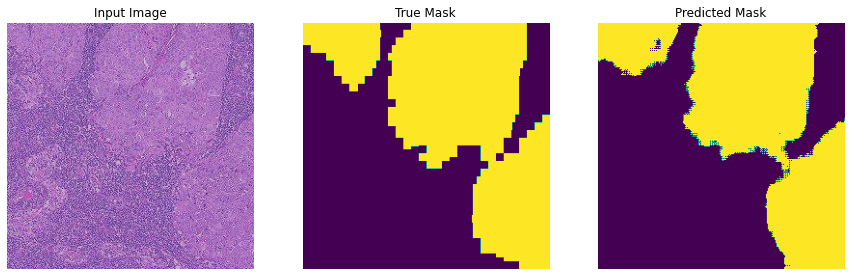

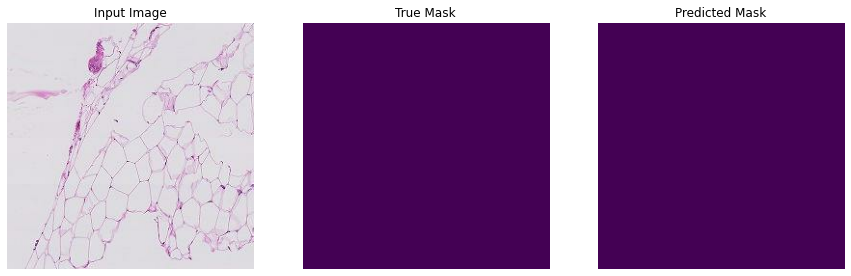

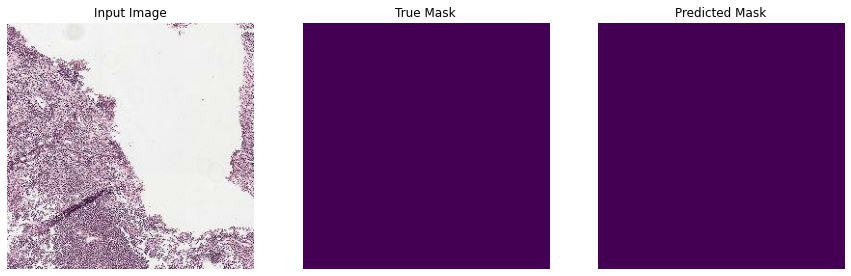

In [ ]:
training_mask_4.evaluate(data_test=generate_4.slides_masks_test,
                         test_num=15)

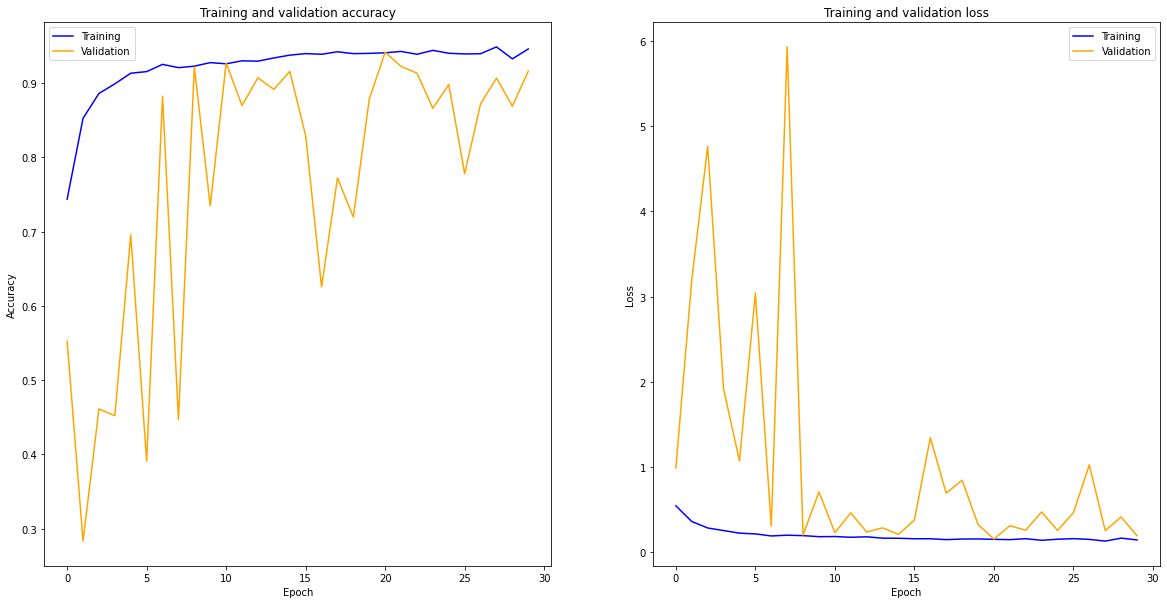

In [ ]:
training_mask_4.draw_curves()

In [ ]:
training_mask_4.UNet.save(ROOT + 'UNet_level_4.h5', overwrite=True)

In [ ]:
training_mask_5 = TrainingForMasks(input_dim=(IMG_SIZE, IMG_SIZE, 3),
                                   num_filters=32,
                                   dropout_rate=0.3)

UNet successfully built.


In [ ]:
training_mask_5.compile_and_fit(data_train=generate_5.slides_masks_train,
                                data_val=generate_5.slides_masks_test,
                                epochs=30)

Epoch 1/30
100/100 [==============================] - 885s 7s/step - loss: 0.4726 - accuracy: 0.7820 - val_loss: 9.5717 - val_accuracy: 0.2997
Epoch 2/30
100/100 [==============================] - 95s 949ms/step - loss: 0.3433 - accuracy: 0.8487 - val_loss: 3.1005 - val_accuracy: 0.2654
Epoch 3/30
100/100 [==============================] - 97s 975ms/step - loss: 0.3173 - accuracy: 0.8609 - val_loss: 1.0658 - val_accuracy: 0.5775
Epoch 4/30
100/100 [==============================] - 98s 980ms/step - loss: 0.2980 - accuracy: 0.8708 - val_loss: 0.4463 - val_accuracy: 0.7972
Epoch 5/30
100/100 [==============================] - 99s 987ms/step - loss: 0.2816 - accuracy: 0.8749 - val_loss: 0.5319 - val_accuracy: 0.7641
Epoch 6/30
100/100 [==============================] - 97s 973ms/step - loss: 0.2980 - accuracy: 0.8648 - val_loss: 0.3621 - val_accuracy: 0.8516
Epoch 7/30
100/100 [==============================] - 99s 988ms/step - loss: 0.2767 - accuracy: 0.8747 - val_loss: 0.3530 - val_accu

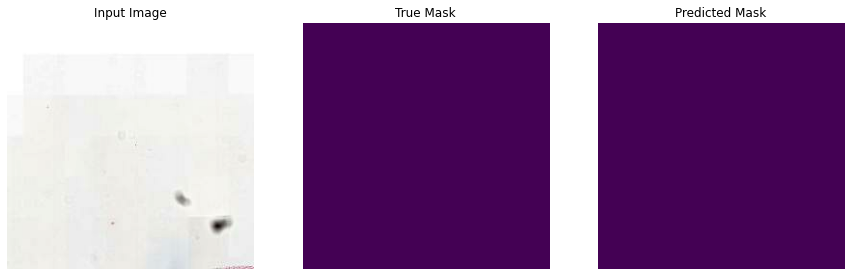

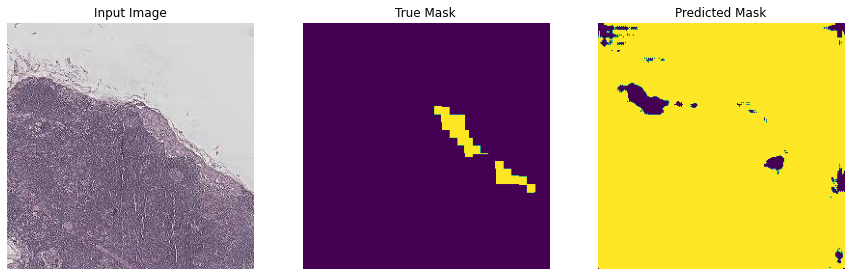

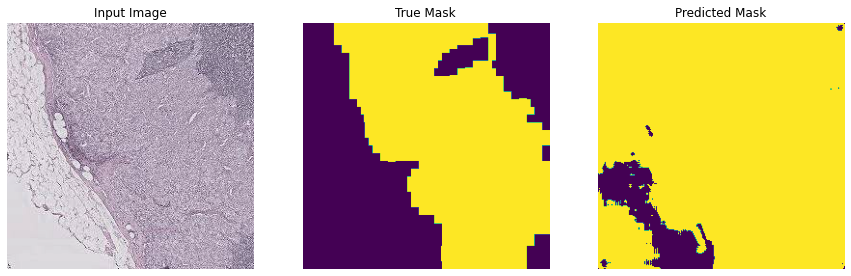

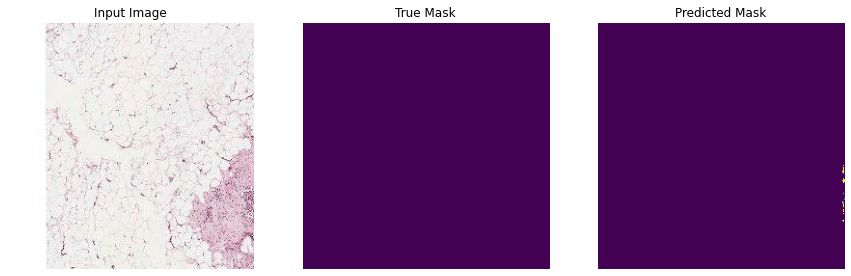

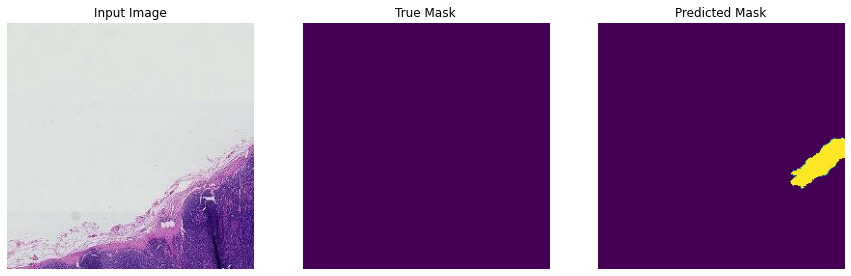

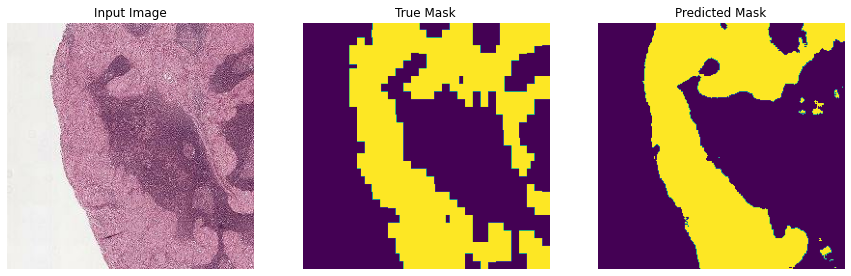

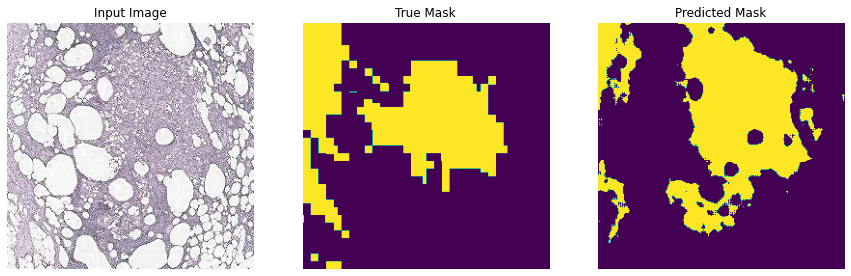

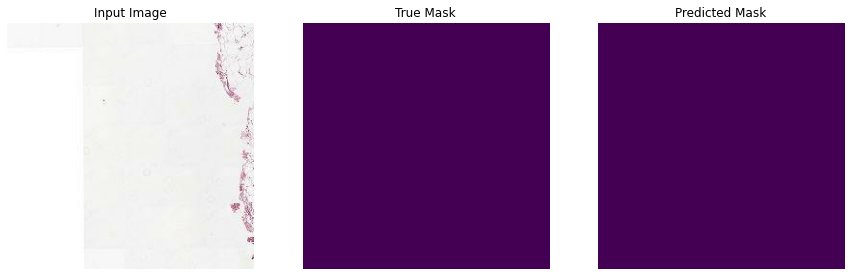

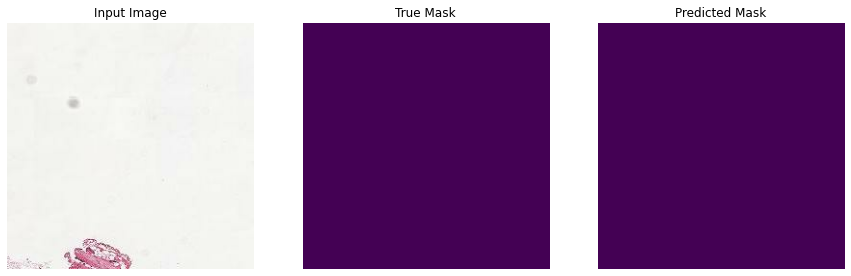

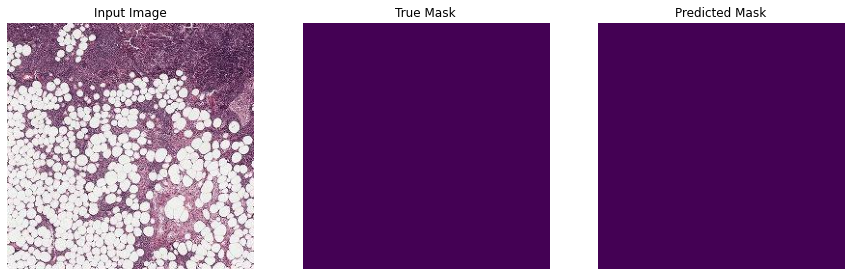

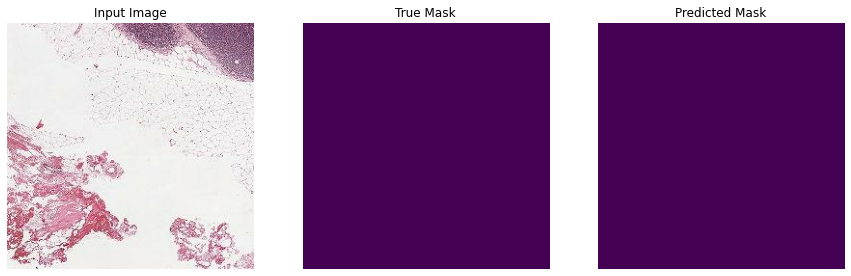

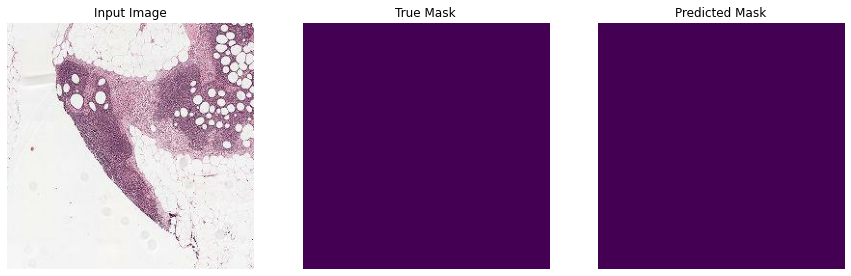

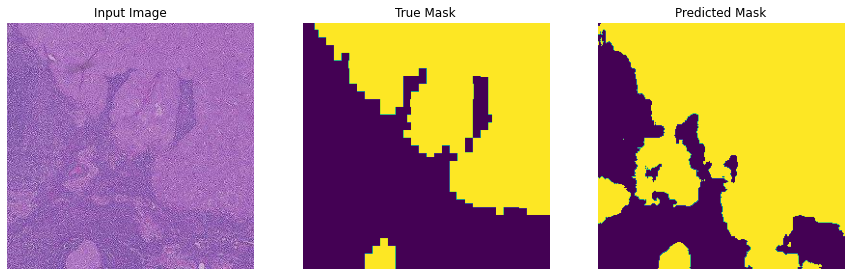

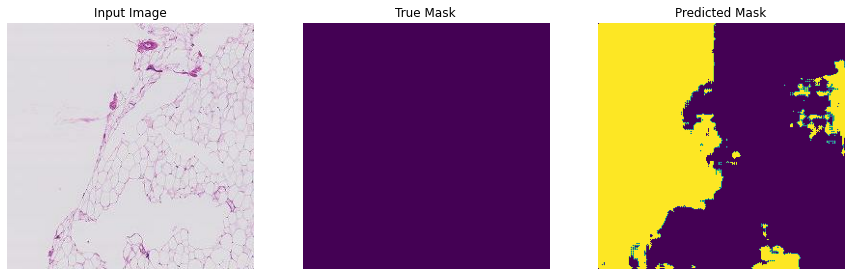

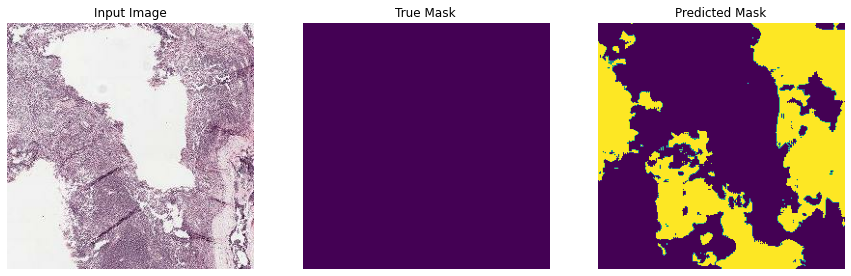

In [ ]:
training_mask_5.evaluate(data_test=generate_5.slides_masks_test,
                         test_num=15)

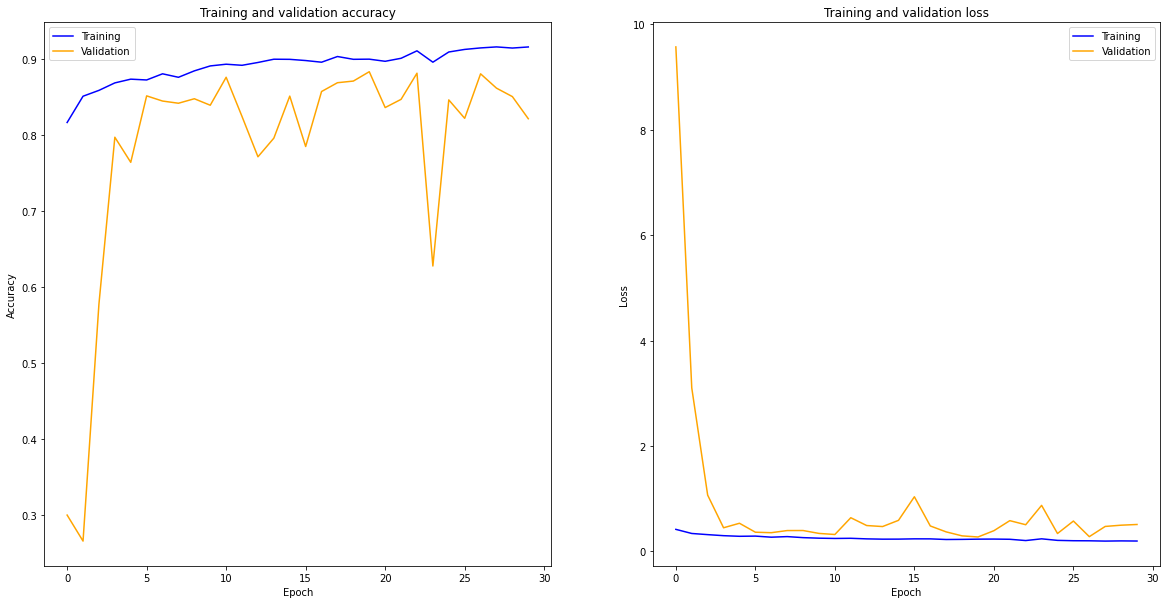

In [ ]:
training_mask_5.draw_curves()

In [ ]:
training_mask_5.UNet.save(ROOT + 'UNet_level_5.h5', overwrite=True)

Although the validation curves are vibrating, we are able to observe a similar tendency with the training ones.